# Generative Adverserial Networks in PyTorch

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

While there are many approaches used for generative modeling, a Generative Adverserial Network takes the following approach:

![image](https://i.imgur.com/6NMdO9u.png)


There are two neural networks: a Generator and a Discriminator. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. This rather simple approach can lead to some astounding results. The following images (source), for instances, were all generated using GANs:

![face](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Example-of-Photorealistic-Human-Faces-Generated-by-a-GAN.png)


**Loading The Data**

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.datasets import MNIST

In [2]:
mnist = MNIST(root = 'data',train=True,download=True,transform=Compose([
    ToTensor(),Normalize(mean=(0.5,),std=(0.5,))
]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Note that we are are transforming the pixel values from the range ```[0, 1]``` to the range ```[-1, 1]```. The reason for doing this will become clear when define the generator network. Let's look at a sample tensor from the data.



In [3]:
img,label = mnist[0]
print('Label:', label)
print(img)
torch.min(img),torch.max(img)



Label: 5
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, 

(tensor(-1.), tensor(1.))

As expected, the pixel values range from -1 to 1. Let's define a helper to denormalize and view the images. This function will also be useful for viewing the generated images.

In [4]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)


Label: 5


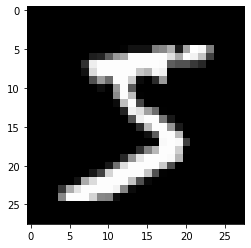

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist,batch_size,shuffle=True)

First Batch
torch.Size([100, 1, 28, 28])
tensor([6, 2, 8, 7, 2, 2, 3, 1, 9, 1, 1, 7, 4, 2, 5, 0, 0, 6, 6, 2, 6, 4, 7, 6,
        3, 7, 6, 0, 3, 2, 2, 1, 2, 9, 9, 7, 7, 0, 6, 1, 8, 9, 8, 7, 7, 4, 8, 7,
        7, 9, 6, 9, 4, 5, 9, 3, 7, 3, 3, 7, 0, 9, 2, 1, 3, 3, 9, 0, 9, 3, 6, 7,
        2, 1, 9, 9, 3, 1, 2, 0, 4, 4, 1, 2, 4, 7, 0, 4, 7, 5, 7, 9, 2, 6, 2, 0,
        6, 4, 8, 3])


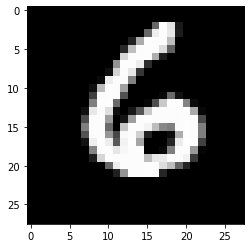

In [7]:
for img_batch,label_batch in data_loader:
    print("First Batch")
    print(img_batch.shape)
    plt.imshow(img_batch[0][0],cmap='gray')
    print(label_batch)
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784.

In [10]:
image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

We use the Leaky ReLU activation for the discriminator.

![leakyrelu](https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png)

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

In [13]:
D.to(device);

## Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [14]:
latent_size = 64

In [15]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

We use the TanH activation function for the output layer of the generator.

![tanh](https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif)

The ReLU activation is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation to work well, especially for higher resolution modeling.

* Note that since the outputs of the TanH activation lie in the range [-1,1], we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [16]:
y = G(torch.randn(2,latent_size))
gen_imgs = denorm(y.reshape((-1,28,28)).detach())

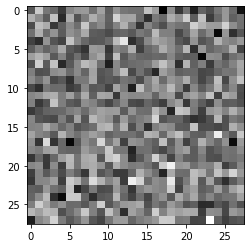

In [17]:
plt.imshow(gen_imgs[0],cmap='gray')

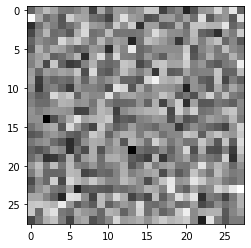

In [18]:
plt.imshow(gen_imgs[1], cmap='gray');

In [19]:
G.to(device);

**Discriminator Training**

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

![binary](https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213)

In [20]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

In [21]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

Here are the steps involved in training the discriminator.

* We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated.

* We first pass a batch of real images, and compute the loss, setting the target labels to 1.

* Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0.

* Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator ```(d_optimizer only affects the D.parameters())```

**Generator Training**

Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

* We generate a batch of images using the generator, pass the into the discriminator.

* We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

* We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device) #creating fake images
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device) # foolig the generator
    g_loss = criterion(D(fake_images), labels)
    
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss,fake_images

## Training the Model

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.

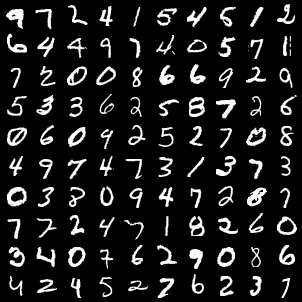

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


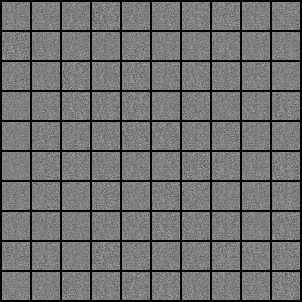

In [25]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)
def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [26]:
num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0861, g_loss: 9.5730, D(x): 0.95, D(G(z)): 0.02
Epoch [0/50], Step [400/600], d_loss: 0.0000, g_loss: 100.0000, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [600/600], d_loss: 0.0000, g_loss: 99.8859, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.0000, g_loss: 100.0000, D(x): 1.00, D(G(z)): 0.00


KeyboardInterrupt: 

In [ ]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [ ]:
Image('./samples/fake_images-0010.png')

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')